In [1]:
import os
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')
import random

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib.ticker import MultipleLocator

from util import array2mat, mat2array, mkdir

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gene_name = 'CLU'
chrom, start, end = 'chr8', 27400000, 27500000
resolution = 10000

In [3]:
diff_hic = {
    'Astro': np.load('./tmp/Astro_{}_diffhic.npy'.format(gene_name), allow_pickle=True).item(),
    'OPC': np.load('./tmp/OPC_{}_diffhic.npy'.format(gene_name), allow_pickle=True).item(),
    'ODC': np.load('./tmp/ODC_{}_diffhic.npy'.format(gene_name), allow_pickle=True).item()
}

In [4]:
from tqdm import tqdm

raw_contacts_dir = '/lmh_data/data/sclab/Lee2019/raw_contacts_data'
csv_df = pd.DataFrame(os.listdir('/lmh_data/data/sclab/Lee2019/Human_single_cell_10kb_csv'))

raw_contacts = pd.DataFrame()
for file in tqdm(os.listdir(raw_contacts_dir)):
    elements = file.split('_')
    csv_filename = csv_df[csv_df[0].str.contains(
        '_'.join([elements[1], elements[4], elements[9], elements[10], elements[11]])
    )].values.reshape(-1)
    if csv_filename.shape[0] != 1:
        print('error')
    _cell_type = csv_filename[0].split('_')[5]
    if _cell_type not in ['Astro', 'OPC', 'ODC']:
        continue
    
    
    _df = pd.read_csv(
        os.path.join(raw_contacts_dir, file),
        sep='\t', header=None, usecols=[1, 2, 3, 4], names=['chr1', 'pos1', 'chr2', 'pos2'],
        compression='gzip'
    )
    # filter
    _df = _df[(_df['chr1']==chrom)&(_df['chr2']==chrom)&
              (_df['pos1']>start)&(_df['pos1']<end)&(_df['pos2']>start)&(_df['pos2']<end)]
    _df['file'] = file
    _df['cell_type'] = _cell_type

    raw_contacts = pd.concat([raw_contacts, _df], axis=0)
raw_contacts

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4238/4238 [28:09<00:00,  2.51it/s]


,chr1,pos1,chr2,pos2,file,cell_type
342923,chr8,27403537,chr8,27417471,GSM3748105_181218_snm3Cseq_hs_21yr_BA10_UMB557...,ODC
342924,chr8,27403537,chr8,27417472,GSM3748105_181218_snm3Cseq_hs_21yr_BA10_UMB557...,ODC
342926,chr8,27405523,chr8,27405339,GSM3748105_181218_snm3Cseq_hs_21yr_BA10_UMB557...,ODC
342927,chr8,27405584,chr8,27405677,GSM3748105_181218_snm3Cseq_hs_21yr_BA10_UMB557...,ODC
342928,chr8,27426909,chr8,27427019,GSM3748105_181218_snm3Cseq_hs_21yr_BA10_UMB557...,ODC
...,...,...,...,...,...,...
1431755,chr8,27493506,chr8,27493791,GSM3752339_190315_snm3Cseq_hs_29yr_BA10_UMB558...,ODC
1431756,chr8,27496273,chr8,27496370,GSM3752339_190315_snm3Cseq_hs_29yr_BA10_UMB558...,ODC
1431757,chr8,27496273,chr8,27496371,GSM3752339_190315_snm3Cseq_hs_29yr_BA10_UMB558...,ODC
1431758,chr8,27498074,chr8,27498104,GSM3752339_190315_snm3Cseq_hs_29yr_BA10_UMB558...,ODC


In [5]:
raw_contacts['bin1'] = ((raw_contacts['pos1']-start)/resolution).astype(int)
raw_contacts['bin2'] = ((raw_contacts['pos2']-start)/resolution).astype(int)

raw_contacts['dynamic'] = 0
def get_dynamic_scores(row):
    # 0.02 from analyse/quality/dynamic_interaction.ipynb
    _diff_hic = diff_hic[row['cell_type']]['diff_hic'].copy() / 0.02
    np.fill_diagonal(_diff_hic, -1)
    
    return _diff_hic[row['bin1'], row['bin2']]
raw_contacts['dynamic'] = raw_contacts.apply(get_dynamic_scores, axis=1)

raw_contacts

,chr1,pos1,chr2,pos2,file,cell_type,bin1,bin2,dynamic
342923,chr8,27403537,chr8,27417471,GSM3748105_181218_snm3Cseq_hs_21yr_BA10_UMB557...,ODC,0,1,0.577583
342924,chr8,27403537,chr8,27417472,GSM3748105_181218_snm3Cseq_hs_21yr_BA10_UMB557...,ODC,0,1,0.577583
342926,chr8,27405523,chr8,27405339,GSM3748105_181218_snm3Cseq_hs_21yr_BA10_UMB557...,ODC,0,0,-1.000000
342927,chr8,27405584,chr8,27405677,GSM3748105_181218_snm3Cseq_hs_21yr_BA10_UMB557...,ODC,0,0,-1.000000
342928,chr8,27426909,chr8,27427019,GSM3748105_181218_snm3Cseq_hs_21yr_BA10_UMB557...,ODC,2,2,-1.000000
...,...,...,...,...,...,...,...,...,...
1431755,chr8,27493506,chr8,27493791,GSM3752339_190315_snm3Cseq_hs_29yr_BA10_UMB558...,ODC,9,9,-1.000000
1431756,chr8,27496273,chr8,27496370,GSM3752339_190315_snm3Cseq_hs_29yr_BA10_UMB558...,ODC,9,9,-1.000000
1431757,chr8,27496273,chr8,27496371,GSM3752339_190315_snm3Cseq_hs_29yr_BA10_UMB558...,ODC,9,9,-1.000000
1431758,chr8,27498074,chr8,27498104,GSM3752339_190315_snm3Cseq_hs_29yr_BA10_UMB558...,ODC,9,9,-1.000000


In [6]:
def two_degree_bc(x_l=10, x_r=90, y_lr=0, y2=10, dots_num=100): #bezier curve
    xt = []
    yt = []
    x_mid = (x_l + x_r)/2
    x_dots12 = np.linspace(x_l, x_mid, dots_num)
    y_dots12 = np.linspace(y_lr, y2, dots_num)
    x_dots23 = np.linspace(x_mid, x_r, dots_num)
    y_dots23 = np.linspace(y2, y_lr, dots_num)
    for i in range(dots_num):
        x = x_dots12[i] + (x_dots23[i]-x_dots12[i])*i / (dots_num-1)
        y = y_dots12[i] + (y_dots23[i]-y_dots12[i])*i / (dots_num-1)
        xt.append(x)
        yt.append(y)
    return (xt, yt)

def plot_loop(ax, ylabel, df, chrom: int, start: int, end: int):
    loops = df[(df['chr1']==chrom)&(df['chr2']==chrom)].copy()
    loops['len'] = lengths = abs(loops["pos2"] - loops["pos1"])

    loops = loops[(loops['pos1']>start)&(loops['pos1']<end)&(loops['pos2']>start)&(loops['pos2']<end)]
#     loops = loops[loops['len'] > 1000]
    loops = loops[loops['dynamic']!=-1]
    loops = loops.apply(lambda x: (x['pos1'], x['pos2'], x['dynamic']), axis=1).values.tolist()

    if len(loops) == 0:
        for i in ['top', 'right', "left", "bottom"]:
            ax.spines[i].set_color('none')
            ax.spines[i].set_linewidth(0)
        return

    _cm = plt.cm.get_cmap('magma')
    top_y = 0
    for loop, length in zip(loops, lengths):
        top = length / max(lengths)
        top = max(0.5, top)
        top = min(0.8, top)
        
        xt, yt = two_degree_bc(x_l=loop[0], x_r=loop[1], y_lr=0, y2=top, dots_num=100)

        ax.plot(xt, yt, color=_cm(loop[2]))
        if max(yt) > top_y:
            top_y = max(yt)

    ax.set_xlim(start,end)
    ax.set_ylim(0,0.5)
    ax.set_ylabel(ylabel, fontsize=8, rotation=0, horizontalalignment='right', verticalalignment='center')
    for i in ['top', 'right']:
        ax.spines[i].set_color('none')
        #ax.spines[i].set_linewidth(0.5)
        
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(1)  
    
    
    ax.tick_params(bottom =False,top=False,left=False,right=False)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

In [7]:
snps = pd.read_csv('CLU_ccv.csv', sep=',')

_snps = snps[['RS_Number', 'Coord_hg19']]
_snps[['chrom', 'start']] = _snps['Coord_hg19'].str.split(':', expand=True)
_snps.rename(columns={'RS_Number': 'name'}, inplace=True)
_snps['start'] = _snps['start'].astype(int)
_snps['end'] = _snps['start'] + 100
_snps = _snps.drop_duplicates(subset='name')
_snps

,name,Coord_hg19,chrom,start,end
0,rs1532278,chr8:27466315,chr8,27466315,27466415
1,rs1532277,chr8:27466181,chr8,27466181,27466281
2,rs4236673,chr8:27464929,chr8,27464929,27465029
3,rs1532276,chr8:27466157,chr8,27466157,27466257
4,rs11787077,chr8:27465312,chr8,27465312,27465412
5,rs11136000,chr8:27464519,chr8,27464519,27464619
6,rs7982,chr8:27462481,chr8,27462481,27462581
7,rs9331896,chr8:27467686,chr8,27467686,27467786
8,rs2070926,chr8:27467821,chr8,27467821,27467921
9,rs2279590,chr8:27456253,chr8,27456253,27456353


In [8]:
def plot_SNP(ax, df, chrom, start, end, line=1, gene_col=[], fontszie=5):
    df = df[df['chrom']==chrom]
    df_plot = df[((df['start'] >= start) & (df['start'] <= end)) | ((df['end'] >= start) & (df['end'] <= end))]
    df_plot = df_plot.sort_values(by='end')
    line = max(line, df_plot.shape[0])
    
    plot_num = df_plot.shape[0]

    ii = 0
    for i,row in df_plot.iterrows():
        ax.bar(x=[i for i in range(row['start'], row['end']+1)], height=2, width=5, bottom=0, \
               edgecolor='black', linewidth=0.3, align='edge', color='b', ecolor=None)
        ax.text(
            row['start'], 3 + (ii % 7) * 1.5, row['name'],
            ha='right', va='center', color='#3366CC', fontsize=fontszie
        )
        ii += 1
            
    ax.set_xlim(start,end)
    ax.set_ylim(top=0, bottom=line)
    if plot_num < line:
        ax.spines['bottom'].set_position(('data', plot_gene_num))
    
    for i in ['left','top','right']:
        ax.spines[i].set_color('none')
        ax.spines[i].set_linewidth(0)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(bottom =True,top=False,left=False,right=False)
    #ax.set_xticklabels("")
    ax.set_yticklabels("")

In [9]:
v19_anno = pd.read_csv('/lmh_data/data/sclab/public/gencode.v19.annotation.gtf',
                       header=None, sep='\t', skiprows=[i for i in range(5)], usecols=[0, 2, 3, 4, 6, 8], names=[
                           'chrom', 'type', 'start', 'end', 'strand', 'info'
                       ])
v19_anno['gene_name'] = v19_anno['info'].str.extract(r'(gene_name ")(\S*)(")')[1]
v19_anno['transcript_name'] = v19_anno['info'].str.extract(r'(transcript_name ")(\S*)(")')[1]
v19_anno

,chrom,type,start,end,strand,info,gene_name,transcript_name
0,chr1,gene,11869,14412,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1
1,chr1,transcript,11869,14409,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
2,chr1,exon,11869,12227,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
3,chr1,exon,12613,12721,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
4,chr1,exon,13221,14409,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
...,...,...,...,...,...,...,...,...
2619439,chrM,transcript,15888,15953,+,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",MT-TT,MT-TT-201
2619440,chrM,exon,15888,15953,+,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",MT-TT,MT-TT-201
2619441,chrM,gene,15956,16023,-,"gene_id ""ENSG00000210196.2""; transcript_id ""EN...",MT-TP,MT-TP
2619442,chrM,transcript,15956,16023,-,"gene_id ""ENSG00000210196.2""; transcript_id ""EN...",MT-TP,MT-TP-201


In [10]:
transcript_info = v19_anno[v19_anno['type']=='transcript'].copy()
transcript_info = transcript_info.set_index('transcript_name')
transcript_info = transcript_info.drop(labels='info', axis=1)
transcript_info = transcript_info.drop(labels='type', axis=1)

exons = v19_anno[(v19_anno['type']=='exon')&(v19_anno['transcript_name'].isin(transcript_info.index))].copy()
exons['blockSizes'] = exons['end'] - exons['start']
exons['blockStarts'] = exons['start']
exons_group = exons.groupby("transcript_name")
transcript_info['blockCount'] = exons_group['blockStarts'].count()
transcript_info['blockSizes'] = exons_group['blockSizes'].apply(list)
transcript_info['blockStarts'] = exons_group['blockStarts'].apply(list)
transcript_info

,chrom,start,end,strand,gene_name,blockCount,blockSizes,blockStarts
transcript_name,,,,,,,,
DDX11L1-002,chr1,11869,14409,+,DDX11L1,3,"[358, 108, 1188]","[11869, 12613, 13221]"
DDX11L1-201,chr1,11872,14412,+,DDX11L1,3,"[355, 108, 1187]","[11872, 12613, 13225]"
DDX11L1-202,chr1,11874,14409,+,DDX11L1,4,"[353, 126, 252, 748]","[11874, 12595, 13403, 13661]"
DDX11L1-001,chr1,12010,13670,+,DDX11L1,6,"[47, 48, 84, 77, 153, 217]","[12010, 12179, 12613, 12975, 13221, 13453]"
WASH7P-202,chr1,14363,29370,-,WASH7P,12,"[49, 153, 111, 146, 140, 131, 201, 158, 43, 10...","[29321, 24738, 18268, 17915, 17602, 17233, 168..."
...,...,...,...,...,...,...,...,...
MT-ND6-201,chrM,14149,14673,-,MT-ND6,1,[524],[14149]
MT-TE-201,chrM,14674,14742,-,MT-TE,1,[68],[14674]
MT-CYB-201,chrM,14747,15887,+,MT-CYB,1,[1140],[14747]


In [11]:
def plot_gene(ax, gene_bed, chrom, start, end, line=1, gene_col=[], fontszie=5):
    gene_bed = gene_bed[gene_bed['chrom']==chrom]
    gene_bed_plot = gene_bed[((gene_bed['start'] >= start) & (gene_bed['start'] <= end)) | ((gene_bed['end'] >= start) & (gene_bed['end'] <= end))]
    gene_bed_plot = gene_bed_plot.sort_values(by='end')
    line = max(line, gene_bed_plot.shape[0])
    
    plot_gene_num = gene_bed_plot.shape[0]
    if line == 1:
        for i,row in gene_bed_plot.iterrows():
            ax.plot((row['start'], row['end']), (0.5, 0.5), color='b')
            starts = row["blockStarts"]
            widths = row["blockSizes"]
            
            ax.bar(x=starts, height=1, width=widths, bottom=0, \
                   edgecolor='black', linewidth=0, align='edge', color='b', ecolor=None)
    else:
        ii = 0
        for i,row in gene_bed_plot.iterrows():
            col = "#3366CC"
            text_col = '#3366CC'
            
            if row["strand"] == "-":
                col = "#EECFA1"
                text_col = '#EECFA1'
            
            #text_col = col
            plot_y = ii%line
            
            if i in gene_col:
                col = "red"
                text_col = "red"
            
            ax.plot((row['start'], row['end']), (plot_y + 0.5, plot_y+0.5), color=col)
            starts = row["blockStarts"]
            widths = row["blockSizes"]
            
            ax.bar(x=starts, height=0.8, width=widths, bottom=plot_y+0.1, \
                   edgecolor=col, linewidth=0.3, align='edge', color=col)
            
            if row['start'] < start:
                    row['start'] = start
            if row['end'] > end:
                    row['end'] = end
            
#             if (gene_bed_plot.iloc[-1]['name'] == i) or (gene_bed_plot.iloc[-2]['name'] == i) or (gene_bed_plot.iloc[-3]['name'] == i):
#                 ax.text(row['start'], plot_y + 0.5, i + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)
#             else:
#                 ax.text(row['end'], plot_y + 0.5, "  " + i, ha='left', va='center',color=text_col, fontsize=fontszie)
            ax.text(row['start'], plot_y + 0.5, i + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)

            ii+=1
            
    ax.set_xlim(start,end)
    ax.set_ylim(top=0, bottom=line)
    if plot_gene_num < line:
        ax.spines['bottom'].set_position(('data', plot_gene_num))
    
    for i in ['left','top','right']:
        ax.spines[i].set_color('none')
        ax.spines[i].set_linewidth(0)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(bottom =True,top=False,left=False,right=False)
    #ax.set_xticklabels("")
    ax.set_yticklabels("")

In [12]:
import pyBigWig

ATAC_ASC_Control = pyBigWig.open('/lmh_data/data/sclab/syn22092838/ASC_Control_hg19.bw')
ATAC_ASC_AD = pyBigWig.open('/lmh_data/data/sclab/syn22092838/ASC_AD_hg19.bw')
ATAC_OPC_AD = pyBigWig.open('/lmh_data/data/sclab/syn22092838/OPC_AD_hg19.bw')
ATAC_ODC_AD = pyBigWig.open('/lmh_data/data/sclab/syn22092838/ODC_AD_hg19.bw')

H3K27ac_AD = pyBigWig.open('/lmh_data/data/sclab/source/AD/ENCFF291ODB.hg19.bw')

In [13]:
def plot_bwTrack(ax, bw, ylabel, chrom, start, end, resolution=20000 , yminx=5, ymaxx=95,rotation=0, fl='%0.2f',color
='#464451'):
    ax.tick_params(bottom=False,top=False,left=True,right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = int((end-start)/resolution)

    plot_list = bw.stats(chrom, start, end, type="mean", nBins=x)
    plot_list = [0 if v is None else v  for v in plot_list]
    
    width = 1
    ax.bar(x=range(0,x), height=plot_list, width=1, bottom=[0]*(x),color=color,align="edge",edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(plot_list,yminx)
    ymax = np.percentile(plot_list,ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')

In [14]:
def _filter_interaction(raw_contacts, bw, chrom, start, end, resolution, threshold, cell_type):
    _atac = bw.stats(chrom, start, end, type="mean", nBins=int((end-start)/resolution))
    _atac = anndata.AnnData(
        X=np.array([_atac]), var={'start': [i for i in range(start, end, resolution)]}, dtype=np.float64
    )
    _atac.var['end'] = _atac.var['start'] + resolution
    _atac = _atac[:, _atac.X>threshold]
    
    _positions = _atac.var.values[:, 0]
    _fragments = list()
    _p = None
    for i in range(start, end, resolution):
        if i not in _positions:
            if _p is None:
                continue
            else:
                _fragments.append((_p, i))
                _p = None
        elif i in _positions:
            if _p is None:
                _p = i
            else:
                continue

    _ranges = set(_fragments)
    _filter = False
    for _range1 in _ranges:
        for _range2 in _ranges:
            _filter |= (
                ((raw_contacts['pos1']>_range1[0])&(raw_contacts['pos1']<_range1[1]))
                &((raw_contacts['pos2']>_range2[0])&(raw_contacts['pos2']<_range2[1]))
            )
            _filter |= (
                ((raw_contacts['pos2']>_range1[0])&(raw_contacts['pos2']<_range1[1]))
                &((raw_contacts['pos1']>_range2[0])&(raw_contacts['pos1']<_range2[1]))
            )

    return raw_contacts[(raw_contacts['cell_type']==cell_type)&_filter]

def pre_track(title=None):
    fig = plt.figure(figsize=(20, 13), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(20, 1)
    ax0 = fig.add_subplot(gs[0:2, 0], facecolor='white')
    ax1 = fig.add_subplot(gs[2:7, 0], facecolor='white')
    ax2 = fig.add_subplot(gs[7, 0], facecolor='white')
    ax3 = fig.add_subplot(gs[8, 0], facecolor='white')
    ax4 = fig.add_subplot(gs[9, 0], facecolor='white')
    ax5 = fig.add_subplot(gs[10, 0], facecolor='white')
    ax6 = fig.add_subplot(gs[11, 0], facecolor='white')
    ax7 = fig.add_subplot(gs[12:14, 0], facecolor='white')
    ax8 = fig.add_subplot(gs[14:16, 0], facecolor='white')
    ax9 = fig.add_subplot(gs[16:18, 0], facecolor='white')
    ax10 = fig.add_subplot(gs[18:20, 0], facecolor='white')

    
    plot_SNP(ax0, _snps, chrom, start, end, line=2, gene_col=[], fontszie=6)
    
    plot_gene(ax1, transcript_info, chrom, start, end, line=10, gene_col=[], fontszie=8)
    
    plot_bwTrack(ax2, ATAC_ASC_Control, "ATAC(Astro&Control)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_bwTrack(ax3, ATAC_ASC_AD, "ATAC(Astro&AD)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_bwTrack(ax4, ATAC_OPC_AD, "ATAC(OPC&AD)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_bwTrack(ax5, ATAC_ODC_AD, "ATAC(ODC&AD)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    
    plot_bwTrack(ax6, H3K27ac_AD, "H3K27ac(AD)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
#     plot_peak(ax6, AD_H3K27ac_peak, "H3K27ac(AD)", chrom, start, end, resolution=100, rotation=0, color='#62D6E3')
    
    plot_loop(ax8, 'contacts(Astro)', _filter_interaction(
        raw_contacts, ATAC_ASC_AD, chrom, start, end, 100, 110, 'Astro'
    ), chrom, start, end)
    plot_loop(ax9, 'contacts(OPC)', _filter_interaction(
        raw_contacts, ATAC_OPC_AD, chrom, start, end, 100, 8, 'OPC'
    ), chrom, start, end)
    plot_loop(ax10, 'contacts(ODC)', _filter_interaction(
        raw_contacts, ATAC_ODC_AD, chrom, start, end, 100, 180, 'ODC'
    ), chrom, start, end)
    
    if title:
        plt.savefig(os.path.join('/lmh_data/work/SEE/analyse/figure_file/', title), format='pdf', bbox_inches='tight')
    plt.show()

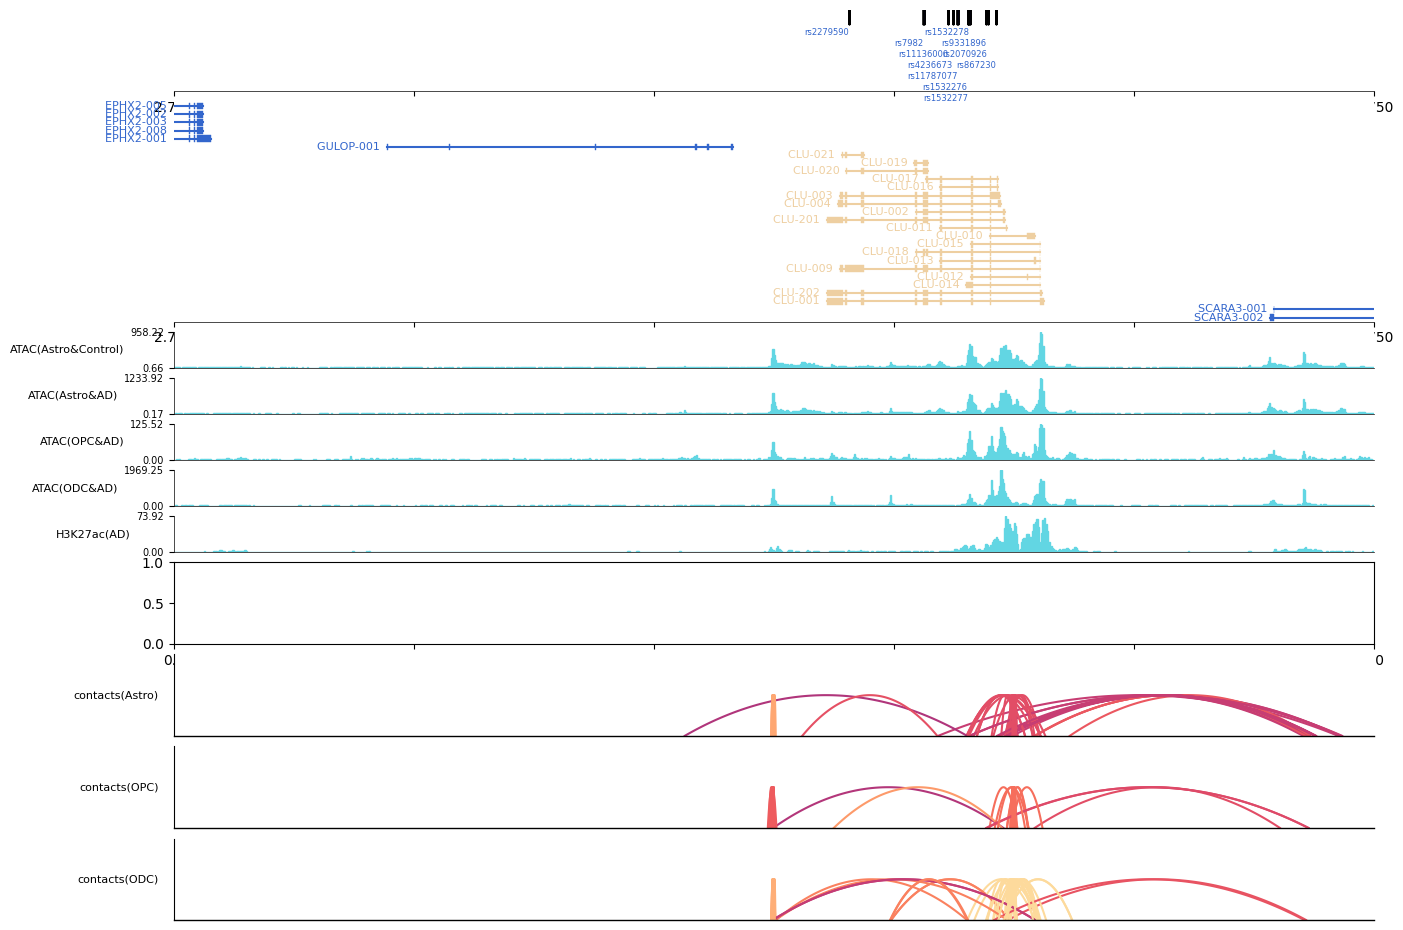

In [15]:
pre_track('Alzheimer/CLU.pdf')